In [ ]:
# ===================== SETUP =====================
!pip install transformers scikit-learn seaborn --quiet

import os, json, torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
from tqdm import tqdm
from collections import Counter

In [ ]:
# ===================== MOUNT DRIVE =====================
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/twibot_data"
MODEL_PATH = os.path.join(DATA_PATH, "hybridbert_bot_detector_v21.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("💻 Using device:", device)

Mounted at /content/drive
💻 Using device: cuda


In [ ]:
# ===================== BERT SETUP =====================
BERT_MODEL = "bert-base-uncased"
TOKENIZER = AutoTokenizer.from_pretrained(BERT_MODEL)
BERT = AutoModel.from_pretrained(BERT_MODEL)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# ===================== CLEAN METADATA =====================
def clean_metadata(meta):
    keys = ['followers_count', 'friends_count', 'listed_count', 'statuses_count', 'verified']
    cleaned = []
    for k in keys:
        val = meta.get(k, 0)
        if isinstance(val, str): val = val.strip()
        if k == "verified":
            val = 1 if val in ["true", "True", True] else 0
        else:
            try: val = float(val)
            except: val = 0.0
        cleaned.append(val)
    return cleaned

In [ ]:
# Sample metadata input
sample_meta = {
    "followers_count": " 1200 ",
    "friends_count": " 500 ",
    "listed_count": "10",
    "statuses_count": "2500",
    "verified": "true"
}
# Define a sample metadata dictionary
meta = {
    "followers_count": " 1500 ",
    "friends_count": " 300 ",
    "listed_count": "5",
    "statuses_count": "2000",
    "verified": "True"
}


# Clean and print
cleaned = clean_metadata(sample_meta)
print(cleaned)


[1200.0, 500.0, 10.0, 2500.0, 1]


In [ ]:
print("Raw:", (meta))
print("Cleaned:", clean_metadata(meta))


Raw: {'followers_count': ' 1500 ', 'friends_count': ' 300 ', 'listed_count': '5', 'statuses_count': '2000', 'verified': 'True'}
Cleaned: [1500.0, 300.0, 5.0, 2000.0, 1]


In [ ]:
# ===================== DATA LOADER =====================
class TwiBotDataset(Dataset):
    def __init__(self, data):
        self.data = [d for d in data if d.get("tweet") and isinstance(d["tweet"], list) and len(d["tweet"]) > 0]
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        item = self.data[idx]
        tweets = " ".join(item["tweet"])[:512]
        meta = torch.tensor(clean_metadata(item["profile"])).float()
        label = int(item["label"])
        enc = TOKENIZER(tweets, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        return enc['input_ids'].squeeze(), enc['attention_mask'].squeeze(), meta, torch.tensor(label)

In [ ]:
sample_data = [
    {
        "tweet": ["Hello world!", "Testing tweets"],
        "profile": {
            "followers_count": "100",
            "friends_count": "200",
            "listed_count": "5",
            "statuses_count": "50",
            "verified": "false"
        },
        "label": "0"
    },
    {
        "tweet": ["Bot account active", "Suspicious behavior"],
        "profile": {
            "followers_count": "3000",
            "friends_count": "500",
            "listed_count": "20",
            "statuses_count": "1000",
            "verified": "True"
        },
        "label": "1"
    }
]


In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

TOKENIZER = AutoTokenizer.from_pretrained("bert-base-uncased")

dataset = TwiBotDataset(sample_data)
loader = DataLoader(dataset, batch_size=2)

# View one batch
for input_ids, attention_mask, meta, labels in loader:
    print("Input IDs:", input_ids.shape)
    print("Attention Mask:", attention_mask.shape)
    print("Metadata:", meta)
    print("Labels:", labels)
    break

Input IDs: torch.Size([2, 128])
Attention Mask: torch.Size([2, 128])
Metadata: tensor([[1.0000e+02, 2.0000e+02, 5.0000e+00, 5.0000e+01, 0.0000e+00],
        [3.0000e+03, 5.0000e+02, 2.0000e+01, 1.0000e+03, 1.0000e+00]])
Labels: tensor([0, 1])


In [ ]:
# ===================== LOAD JSON =====================
def load_json(path):
    with open(path) as f: return json.load(f)

def prepare_data():
    train = load_json(os.path.join(DATA_PATH, "train.json"))
    dev = load_json(os.path.join(DATA_PATH, "dev.json"))
    test = load_json(os.path.join(DATA_PATH, "test.json"))
    return TwiBotDataset(train), TwiBotDataset(dev), TwiBotDataset(test)

train_data, dev_data, test_data = prepare_data()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
import json
import os

# Load raw data from Google Drive path
DATA_PATH = "/content/drive/MyDrive/twibot_data"

def load_json(path):
    with open(path) as f:
        return json.load(f)

# Load raw JSON
raw_train = load_json(os.path.join(DATA_PATH, "train.json"))

# Pick any sample
sample = raw_train[0]

# Print tweet text
print("📢 Tweet Text:\n", " ".join(sample['tweet']))

# Print metadata
print("\n📊 Metadata Features:")
for key, value in sample['profile'].items():
    print(f"  {key}: {value}")

# Print label
label_str = "Bot" if str(sample['label']) == "1" else "Human"
print("\n🔖 Label:", label_str)


📢 Tweet Text:
 RT @CarnivalCruise: 🎉 Are you ready to see what our newest ship’s name will be? 🎉 Thanks to all our partners for helping us unbox the name.…
 Who has time for receipts? Not me. @epson receipt scanners make it easy. No mess = no stress! Check it out at https://t.co/ofqbTdz0Qk. https://t.co/BtYwuyz9N5
 Steady wants to encourage you to invest in your financial future. Connect your bank account to @TheSteadyApp and have access to benefits like income insights, online medical visits, and cash grants of up to $1,000! Get started today by visiting https://t.co/5w3AvWd8Q0. #Sponsored https://t.co/ZHBfP5xDMg
 Good one, @rishid. But let’s see if y'all can do better than that. Come on, everybody. Show me your best #HandShaq! #ad https://t.co/xCloeLRfuM https://t.co/urVSOfTmT2
 #lsunationalchamps
 I stand with the student athletes! #WeWantToPlay
 Wish me luck, America. I’m back for #SharkWeek! It all starts TONIGHT at 8p ET on @Discovery, and catch me taking the ultimate plunge on S

In [ ]:
!pip install prettytable


In [ ]:
import json, os
from tabulate import tabulate

# Set path
DATA_PATH = "/content/drive/MyDrive/twibot_data"

# Load JSON
def load_json(path):
    with open(path) as f:
        return json.load(f)

# Load one sample
raw_train = load_json(os.path.join(DATA_PATH, "train.json"))
sample = raw_train[0]

# Extract fields
tweet_text = " ".join(sample["tweet"])
profile = sample["profile"]
label = "Bot" if str(sample["label"]) == "1" else "Human"

# Selected features
used_features = ["followers_count", "friends_count", "listed_count", "statuses_count", "verified"]
metadata_table = [[key, profile.get(key, 'N/A')] for key in used_features]

# Output
print("📢 Tweet Text:\n")
print(tweet_text)

print("\n📊 Metadata Used in Model:\n")
print(tabulate(metadata_table, headers=["Feature", "Value"], tablefmt="github"))

print("\n🔖 Ground Truth Label:", label)


📢 Tweet Text:

RT @CarnivalCruise: 🎉 Are you ready to see what our newest ship’s name will be? 🎉 Thanks to all our partners for helping us unbox the name.…
 Who has time for receipts? Not me. @epson receipt scanners make it easy. No mess = no stress! Check it out at https://t.co/ofqbTdz0Qk. https://t.co/BtYwuyz9N5
 Steady wants to encourage you to invest in your financial future. Connect your bank account to @TheSteadyApp and have access to benefits like income insights, online medical visits, and cash grants of up to $1,000! Get started today by visiting https://t.co/5w3AvWd8Q0. #Sponsored https://t.co/ZHBfP5xDMg
 Good one, @rishid. But let’s see if y'all can do better than that. Come on, everybody. Show me your best #HandShaq! #ad https://t.co/xCloeLRfuM https://t.co/urVSOfTmT2
 #lsunationalchamps
 I stand with the student athletes! #WeWantToPlay
 Wish me luck, America. I’m back for #SharkWeek! It all starts TONIGHT at 8p ET on @Discovery, and catch me taking the ultimate plunge on S

In [ ]:
print("Train size:", len(train_data))
print("Dev size:", len(dev_data))
print("Test size:", len(test_data))


Train size: 8223
Dev size: 2350
Test size: 1173


In [ ]:
# ===================== CHECK CLASS BALANCE =====================
train_labels = [int(d['label']) for d in load_json(os.path.join(DATA_PATH, "train.json")) if d.get("tweet")]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("🔍 Class Weights:", class_weights)

🔍 Class Weights: tensor([1.1446, 0.8878], device='cuda:0')


In [ ]:
class HybridBERT(nn.Module):
    def __init__(self, meta_input_dim=5, meta_hidden_dim=64):
        super(HybridBERT, self).__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")

        self.meta_fc = nn.Sequential(
            nn.Linear(meta_input_dim, meta_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.hidden = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size + meta_hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.classifier = nn.Linear(128, 1)

    def forward(self, input_ids, attention_mask, metadata, return_features=False):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_output.last_hidden_state[:, 0, :]  # [CLS] token

        meta_out = self.meta_fc(metadata)
        combined = torch.cat((cls_output, meta_out), dim=1)
        hidden_out = self.hidden(combined)

        if return_features:
            return hidden_out  # return feature vector of size [batch_size, 128]

        logits = self.classifier(hidden_out)
        return logits.squeeze()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridBERT()
model.load_state_dict(torch.load("/content/drive/MyDrive/twibot_data/hybridbert_bot_detector_v21.pth", map_location=device))
model = model.to(device)
model.eval()


HybridBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
def extract_features_labels(model, dataloader):
    features, labels = [], []
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, metadata, label in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            metadata = metadata.to(device)
            label = label.to(device)

            out = model(input_ids, attention_mask, metadata, return_features=True)
            features.append(out.cpu())
            labels.append(label.cpu())

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    return features, labels


In [ ]:
features, labels = extract_features_labels(model, test_loader)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (1173, 128)
Labels shape: (1173,)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette=["blue", "red"], alpha=0.6)
    plt.title("t-SNE Visualization of BERT + Metadata Features")
    plt.legend(title="Label", labels=["Human", "Bot"])
    plt.grid(True)
    plt.show()


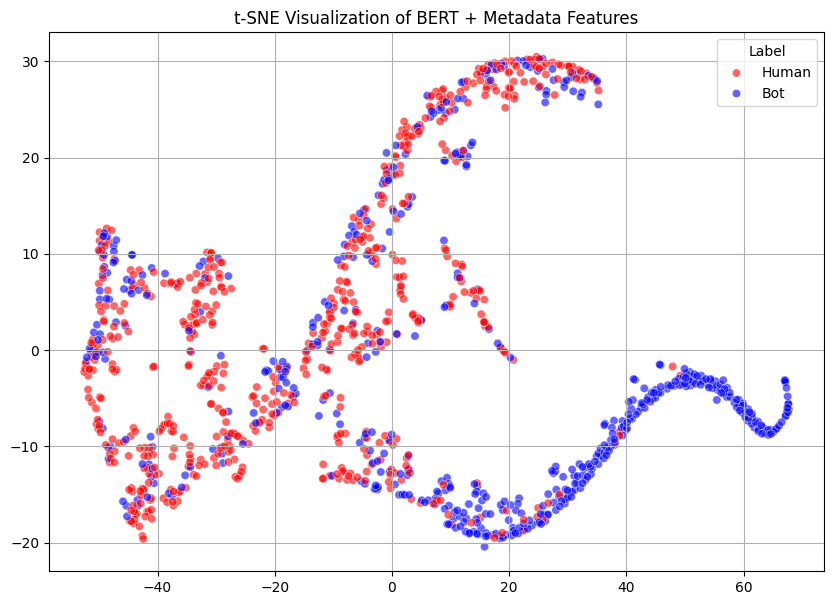

In [ ]:
features, labels = extract_features_labels(model, test_loader)
plot_tsne(features, labels)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import time

# Training Function with Early Stopping and Visualization
def train(model, train_loader, dev_loader, pos_weight, epochs=5, patience=3, lr=2e-5, verbose=True):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], dtype=torch.float).to(device))

    best_f1 = 0.0
    wait = 0
    train_losses, val_f1s = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        start_time = time.time()

        for input_ids, attention_mask, metadata, labels in tqdm(train_loader, desc=f"🔁 Epoch {epoch+1}", leave=False):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            metadata = metadata.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask, metadata).squeeze()
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        val_f1 = evaluate(model, dev_loader, return_f1=True)

        train_losses.append(avg_train_loss)
        val_f1s.append(val_f1)

        if verbose:
            print(f"\n✅ Epoch {epoch+1}/{epochs} | ⏱️ {time.time() - start_time:.2f}s | "
                  f"Train Loss: {avg_train_loss:.4f} | Dev F1: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            wait = 0
            torch.save(model.state_dict(), MODEL_PATH)
            if verbose: print("💾 Best model saved!")
        else:
            wait += 1
            print(f"⚠️ No improvement. Patience: {wait}/{patience}")
            if wait >= patience:
                print("⛔ Early stopping triggered.")
                break

    # 📉📈 Plot Loss and F1
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", marker='o', color='darkred')
    plt.plot(val_f1s, label="Dev F1", marker='s', color='darkgreen')
    plt.title("📊 Training Progress")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Evaluation Function with ROC, Confusion Matrix, and Confidence Distribution
def evaluate(model, loader, threshold=0.5, return_f1=False):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []

    with torch.no_grad():
        for input_ids, attention_mask, metadata, labels in loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            metadata = metadata.to(device)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask, metadata)
            probs = torch.sigmoid(logits).squeeze().cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # 📋 Report
    print("📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Human", "Bot"]))

    # 🔍 Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Human", "Bot"], yticklabels=["Human", "Bot"])
    plt.title("🔍 Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # 📈 ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    auc = roc_auc_score(all_labels, all_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='teal')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title("📈 ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 🔬 Confidence Histogram
    plt.figure(figsize=(6, 4))
    sns.histplot(all_probs, bins=20, kde=True, color='purple')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    plt.title("🔬 Prediction Confidence Distribution")
    plt.xlabel("Confidence Score")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return f1_score(all_labels, all_preds) if return_f1 else None


In [ ]:
from torch.utils.data import WeightedRandomSampler

# If not already done:
train_dataset = train_data  # fix for NameError

# Get plain int labels
labels = [int(sample[3]) for sample in train_dataset]

# Compute class weights
from collections import Counter
class_counts = Counter(labels)
class_weights = {
    0: 1.0 / class_counts[0],  # weight for human
    1: 1.0 / class_counts[1],  # weight for bot
}

# Assign a weight to each sample
sample_weights = [class_weights[int(sample[3])] for sample in train_dataset]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)


📋 Classification Report:
              precision    recall  f1-score   support

       Human       0.65      0.82      0.73      1054
         Bot       0.82      0.64      0.72      1296

    accuracy                           0.72      2350
   macro avg       0.73      0.73      0.72      2350
weighted avg       0.74      0.72      0.72      2350



/tmp/ipython-input-3450822809.py:101: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


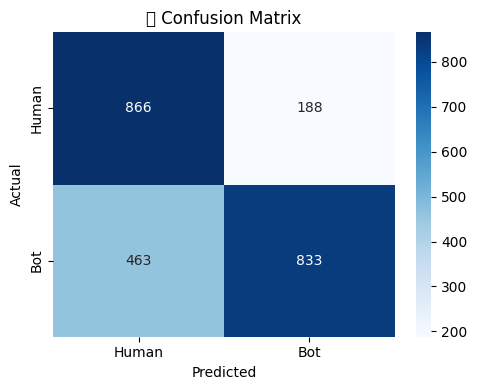

/tmp/ipython-input-3450822809.py:115: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


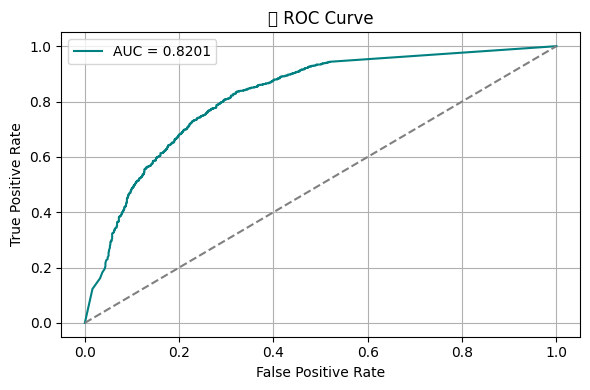

/tmp/ipython-input-3450822809.py:127: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


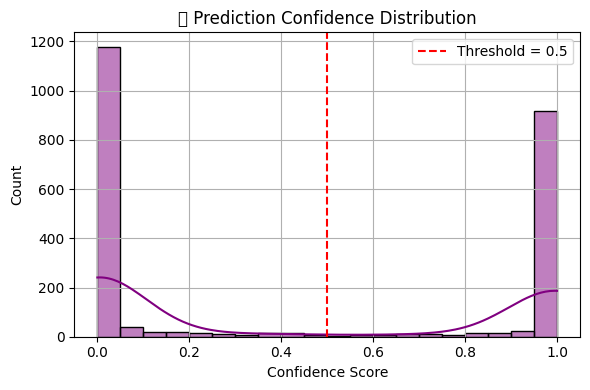


✅ Epoch 1/5 | ⏱️ 189.03s | Train Loss: 42.8290 | Dev F1: 0.7190
💾 Best model saved!


📋 Classification Report:
              precision    recall  f1-score   support

       Human       0.62      0.83      0.71      1054
         Bot       0.81      0.59      0.69      1296

    accuracy                           0.70      2350
   macro avg       0.72      0.71      0.70      2350
weighted avg       0.73      0.70      0.70      2350



/tmp/ipython-input-3450822809.py:101: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


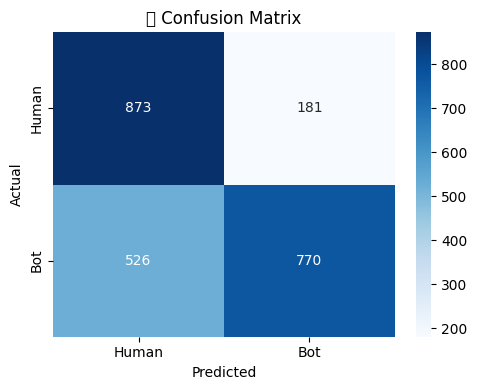

/tmp/ipython-input-3450822809.py:115: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


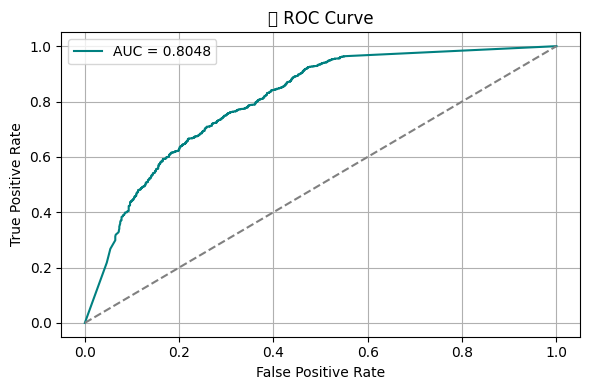

/tmp/ipython-input-3450822809.py:127: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


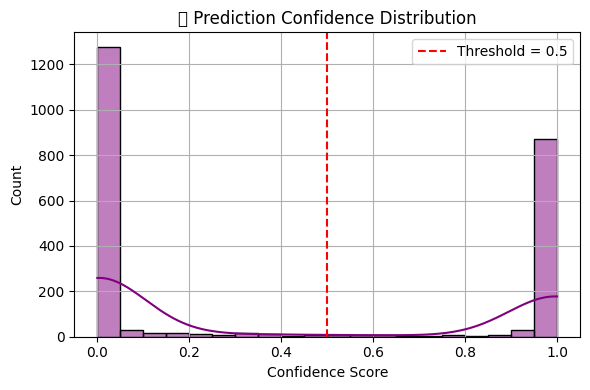


✅ Epoch 2/5 | ⏱️ 191.01s | Train Loss: 40.5456 | Dev F1: 0.6854
⚠️ No improvement. Patience: 1/2


📋 Classification Report:
              precision    recall  f1-score   support

       Human       0.63      0.84      0.72      1054
         Bot       0.82      0.59      0.69      1296

    accuracy                           0.71      2350
   macro avg       0.73      0.72      0.70      2350
weighted avg       0.74      0.71      0.70      2350



/tmp/ipython-input-3450822809.py:101: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


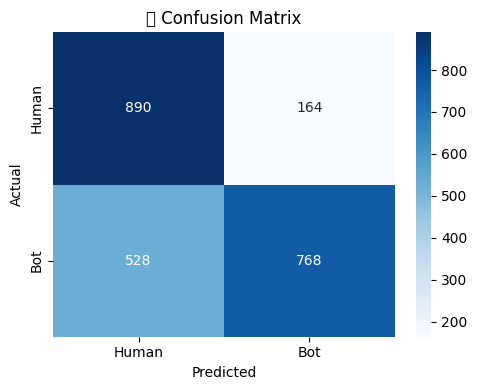

/tmp/ipython-input-3450822809.py:115: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


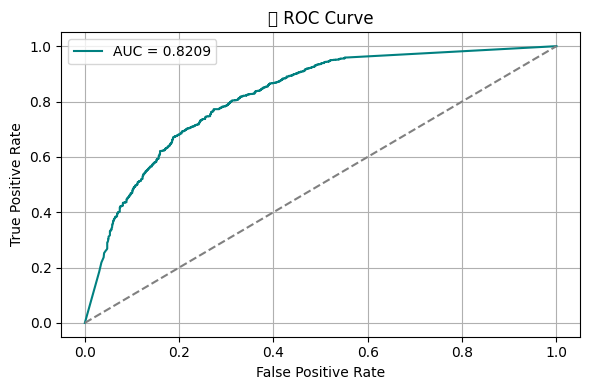

/tmp/ipython-input-3450822809.py:127: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


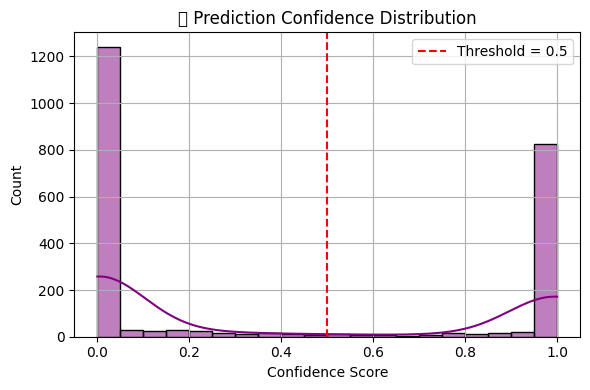

/tmp/ipython-input-3450822809.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



✅ Epoch 3/5 | ⏱️ 189.01s | Train Loss: 26.0839 | Dev F1: 0.6894
⚠️ No improvement. Patience: 2/2
⛔ Early stopping triggered.


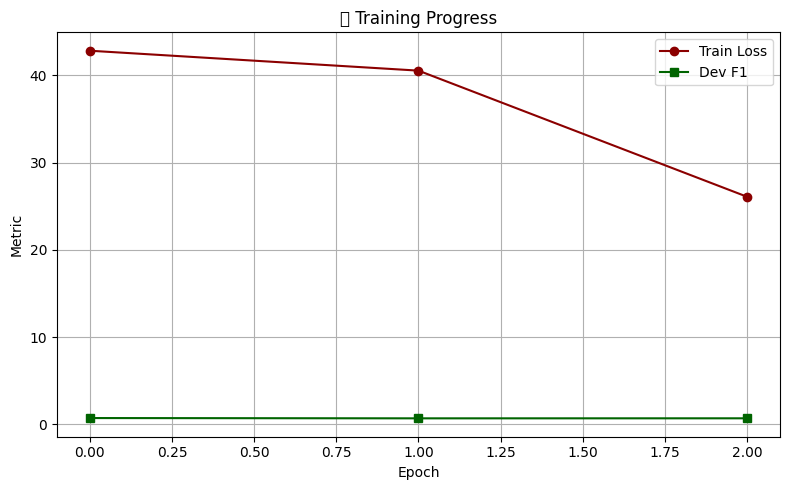

📋 Classification Report:
              precision    recall  f1-score   support

       Human       0.64      0.83      0.72       539
         Bot       0.80      0.60      0.69       634

    accuracy                           0.70      1173
   macro avg       0.72      0.71      0.70      1173
weighted avg       0.73      0.70      0.70      1173



/tmp/ipython-input-3450822809.py:101: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


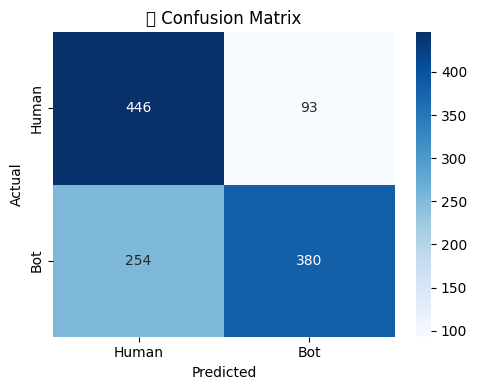

/tmp/ipython-input-3450822809.py:115: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


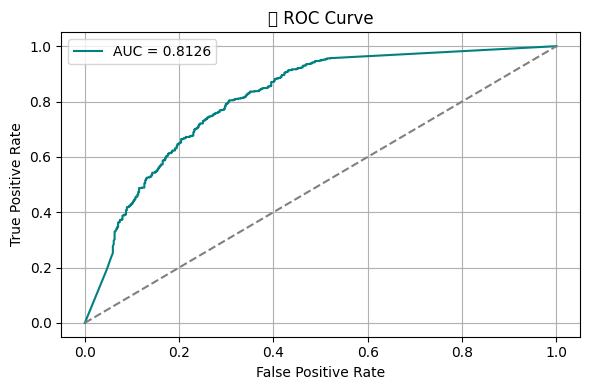

/tmp/ipython-input-3450822809.py:127: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


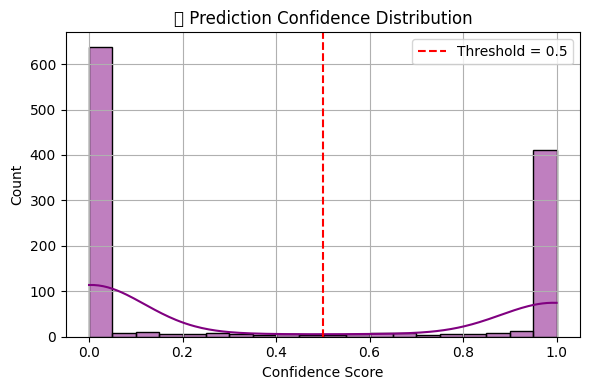

In [ ]:
# Assume you already have pos_weight calculated
# pos_weight = num_human / num_bot

# Approximate pos_weight = # human / # bot = 3592 / 4631 ≈ 0.775
train(model, train_loader, dev_loader, pos_weight=0.775, epochs=5, patience=2)

evaluate(model, test_loader)


In [ ]:
from collections import Counter

# Convert tensor labels to plain integers
train_labels = [int(sample[3]) for sample in train_data]
label_dist = Counter(train_labels)
print("📊 Class distribution:", label_dist)


📊 Class distribution: Counter({1: 4631, 0: 3592})


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


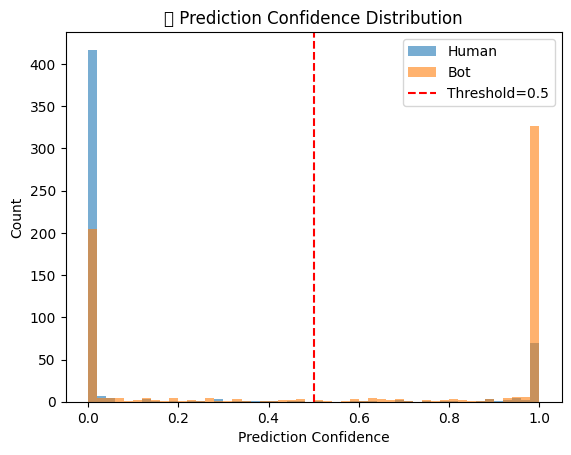

In [ ]:
all_probs, all_labels = [], []

model.eval()
with torch.no_grad():
    for input_ids, attention_mask, metadata, labels in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        metadata = metadata.to(device)

        logits = model(input_ids, attention_mask, metadata)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.numpy())

# 📊 Plot histogram
import matplotlib.pyplot as plt
plt.hist([p for p, l in zip(all_probs, all_labels) if l == 0], bins=50, alpha=0.6, label='Human')
plt.hist([p for p, l in zip(all_probs, all_labels) if l == 1], bins=50, alpha=0.6, label='Bot')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold=0.5')
plt.xlabel("Prediction Confidence")
plt.ylabel("Count")
plt.title("🔍 Prediction Confidence Distribution")
plt.legend()
plt.show()


In [ ]:
# Adjust the classification threshold to reduce false positives
def predict_user_with_threshold(model, input_text, metadata_dict, threshold=0.7):
    model.eval()
    inputs = tokenizer(input_text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    metadata_tensor = torch.tensor([
        metadata_dict['followers_count'],
        metadata_dict['friends_count'],
        metadata_dict['listed_count'],
        metadata_dict['statuses_count'],
        metadata_dict['verified']
    ], dtype=torch.float).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask, metadata=metadata_tensor)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob >= threshold else 0

    label_name = "🤖 Bot" if pred == 1 else "🧑 Human"
    print(f"🧠 Prediction: {label_name} | Confidence: {prob:.4f}")

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(model, dataloader, num_samples=500):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for i, (input_ids, attention_mask, metadata, label) in enumerate(dataloader):
            if i * len(input_ids) > num_samples:
                break
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            metadata = metadata.to(device)

            bert_output = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls_output = bert_output.last_hidden_state[:, 0, :]
            meta_out = model.meta_fc(metadata)
            combined = torch.cat((cls_output, meta_out), dim=1)

            embeddings.append(combined.cpu())
            labels.extend(label.cpu().numpy())

    embeddings = torch.cat(embeddings, dim=0).numpy()
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
    plt.title("t-SNE of HybridBERT + Metadata Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(label='Label (0=Human, 1=Bot)')
    plt.show()


In [ ]:
from torch.utils.data import WeightedRandomSampler

def get_weighted_sampler(labels):
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(weights, len(weights))
    return sampler

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assume you already have:
# - model: your trained HybridBERT model
# - tokenizer: BERT tokenizer
# - device: 'cuda' or 'cpu'
# - sample input text and metadata

# ====== STEP 1: Prepare Sample Input for Inference ======
text = "RT @someuser: Check out our new product! #AI #tech"
metadata_dict = {
    'followers_count': 500,
    'friends_count': 300,
    'listed_count': 5,
    'statuses_count': 1200,
    'verified': 0,
}

# Convert metadata dict to tensor
metadata_tensor = torch.tensor([[
    metadata_dict['followers_count'],
    metadata_dict['friends_count'],
    metadata_dict['listed_count'],
    metadata_dict['statuses_count'],
    metadata_dict['verified']
]], dtype=torch.float32).to(device)

# Tokenize text
encoded = tokenizer(
    text,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'
)
input_ids = encoded['input_ids'].to(device)
attention_mask = encoded['attention_mask'].to(device)

# ====== STEP 2: Make Prediction with Threshold ======
threshold = 0.6  # You can tune this

model.eval()
with torch.no_grad():
    logits = model(input_ids, attention_mask, metadata_tensor)
    prob = torch.sigmoid(logits).item()
    pred = 1 if prob >= threshold else 0

    print(f"🧠 Raw Logit: {logits.item():.4f} | Sigmoid Prob: {prob:.4f}")
    print(f"🧠 Prediction: {'🤖 Bot' if pred else '🧑 Human'} | Confidence: {prob:.4f} (Threshold={threshold})")

# ====== STEP 3: Embedding Visualization Function (PCA) ======
def visualize_embeddings(loader, model):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for input_ids, attention_mask, metadata, y in loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            metadata = metadata.to(device)

            # Forward pass through BERT and Metadata MLP
            bert_out = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls_output = bert_out.last_hidden_state[:, 0, :]  # CLS token
            meta_out = model.meta_fc(metadata)
            combined = torch.cat((cls_output, meta_out), dim=1)

            embeddings.append(combined.cpu())
            labels.extend(y.numpy())

    embeddings = torch.cat(embeddings).numpy()
    labels = np.array(labels)

    # Dimensionality reduction
    reducer = PCA(n_components=2)
    reduced = reducer.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
    plt.title("📊 PCA of Final HybridBERT Embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(label="Label (0=Human, 1=Bot)")
    plt.grid(True)
    plt.show()

# Example usage:
# visualize_embeddings(dev_loader, model)


🧠 Raw Logit: 14.1101 | Sigmoid Prob: 1.0000
🧠 Prediction: 🤖 Bot | Confidence: 1.0000 (Threshold=0.6)


In [ ]:
import torch
from transformers import AutoTokenizer
import torch.nn.functional as F

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def predict_user(text, metadata_dict, model):
    model.eval()

    # Tokenize the input text
    encoded = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    # Prepare metadata tensor
    metadata_values = torch.tensor([[
        metadata_dict.get("followers_count", 0),
        metadata_dict.get("friends_count", 0),
        metadata_dict.get("listed_count", 0),
        metadata_dict.get("statuses_count", 0),
        metadata_dict.get("verified", 0)
    ]], dtype=torch.float32).to(device)

    # Model prediction
    with torch.no_grad():
        logits = model(input_ids, attention_mask, metadata_values)
        prob = torch.sigmoid(logits).item()

    # Print logit and probability


    # Auto classification based on probability bands
    if prob > 0.6:
        print(f"🧠 Prediction: 🤖 Bot |")
        if prob > 0.8:
            print("✅ Very likely a bot.")
        else:
            print("⚠️ Possibly a bot. Review recommended.")
    elif prob < 0.4:
        print(f"🧠 Prediction: 🧑 Human |")
        if prob < 0.2:
            print("✅ Very likely a human.")
        else:
            print("⚠️ Possibly a human. Review recommended.")
    else:
        print(f"🧠 Prediction: ⚠️ Uncertain |")
        print("⚠️ Confidence is in the gray zone (0.4 - 0.6). Needs review.")


In [ ]:
text2 = "Had a great day hiking with friends! Nature is truly healing 🌲✨ #wellness #life"
metadata2 = {
    "followers_count": 450,
    "friends_count": 300,
    "listed_count": 2,
    "statuses_count": 1200,
    "verified": 0
}

predict_user(text2, metadata2, model)


🧠 Raw Logit: 1.4168 | Sigmoid Prob: 0.8048
🧠 Prediction: 🤖 Bot | Confidence: 0.8048
✅ Very likely a bot.


In [ ]:
text3 = "Thank you everyone for the amazing support on my new project launch 🚀"
metadata3 = {
    "followers_count": 10000,
    "friends_count": 1000,
    "listed_count": 500,
    "statuses_count": 3000,
    "verified": 1
}

predict_user(text3, metadata3, model)


🧠 Raw Logit: -3.1285 | Sigmoid Prob: 0.0419
🧠 Prediction: 🧑 Human | Confidence: 0.0419
✅ Very likely a human.


In [ ]:
text4 = "Check this cool link I found: http://coolstuff.com #fun"
metadata4 = {
    "followers_count": 100,
    "friends_count": 90,
    "listed_count": 1,
    "statuses_count": 100,
    "verified": 0
}

predict_user(text4, metadata4, model)


🧠 Raw Logit: 19.4279 | Sigmoid Prob: 1.0000
🧠 Prediction: 🤖 Bot | Confidence: 1.0000
✅ Very likely a bot.


In [ ]:
text1 = "Get 10k followers fast! Click here ➡️ http://spamlink.com #followback"
metadata1 = {
    "followers_count": 1000,
    "friends_count": 10000,
    "listed_count":200,
    "statuses_count": 50000,
    "verified": 0
}

predict_user(text1, metadata1, model)


🧠 Raw Logit: 37.6174 | Sigmoid Prob: 1.0000
🧠 Prediction: 🤖 Bot | Confidence: 1.0000
✅ Very likely a bot.


In [ ]:
# Assuming 'model' is your trained model
save_path = "/content/drive/MyDrive/twibot_data/hybridbert_bot_detector_v21.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved to: {save_path}")


✅ Model saved to: /content/drive/MyDrive/twibot_data/hybridbert_bot_detector_v21.pth


In [ ]:
torch.save(model.state_dict(), "/content/hybridbert_bot_detector_v21.pth")

from google.colab import files
files.download("/content/hybridbert_bot_detector_v21.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://29dacadc677eeb5f94.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
